<strong>Classificatore Binario Scania</strong><br>
L'obiettivo del codice che segue è quello di dimostrare una possibile integrazione fra una soluzione di machine learning implementata tramite la libreria open source pytorch e una pipeline di processamento di big data formata dal broker di messagistica Apache Kafka e il framework di calcolo open source Apache Spark. L'attività di progetto verte nello specifico sul processamento di dati di monitoraggio di motori di camion Scania provenienti da dataset pubblici, la cui analisi ha come scopo l'identificazione di eventuali guasti. Quanto appena descritto viene realizzato tramite classificazione binaria, un tipo di supervised learning, branca del machine learning che parte da dati strutturati in categorie specifiche, sui quali fare osservazioni su esempi pratici per etichettare nuovi dati. Questo viene costruito attraverso il modello della rete neurale basato sulle API pytorch che lavora sui dati che spark estrae da topic kafka e pre-processa prima della computazione vera e propria. L'integrazione tra gli ambienti eterogenei sopracitati è stata resa più facile e possibile attraverso il linguaggio di scrypting python utilizzato come ponte comune a Spark (che supporta anche Java e Scala) e pytorch. 

In [1]:
import os
import findspark
findspark.init()

os.environ['PYSPARK_SUBMIT_ARGS'] ='--master local[4] --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1 pyspark-shell'

il codice contenuto nella cella sovrastante è di vitale importanza in quanto viene utilizzato per lanciare l'applicazione, in particolare con il primo flag --master local[4] si istruisce il framework spark di distribuire il calcolo in modo equo su 4 core in esecuzione sulla macchina locale, mentre il secondo --packages serve per includere dipendenze esterne fondamentali per la costruzione della pipeline basata sull'integrazione fra kafka e spark stesso. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler
from multiprocessing.pool import ThreadPool
from torch.profiler import profile, record_function, ProfilerActivity

Per poter utilizzare le API di pytorch per la costruzione della rete neurale utilizzata per la classificazione e quelle di spark per il processamento dei dati estratti dal topic kafka, si utilizza un classico formalismo python. L'istruzione import viene utilizzata per cercare un modulo, eventualmente inizializzarlo e definire uno o più nomi nello spazio dei nomi locale attraverso cui avere accesso alle funzioni di quel modulo. Nel caso specifico dai moduli torch.* si estraggono le funzionalità per la costruzione della rete neurale, il training e il testing, mentre quelli pyspark.* includono le API per l'estrazione dei dati dal topic kafka e il preprocessing effettuato da spark in preparazione alla computazione per la classificazione.   

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
class BinaryClassificationNetwork(nn.Module):
    def __init__(self, features_num, neurons):
        super(BinaryClassificationNetwork, self).__init__()
        self.l1 = nn.Linear(features_num, neurons)
        self.output = nn.Linear(neurons, 1)
    def forward(self, input):
        x = nn.ReLU()(self.l1(input))
        out = nn.Sigmoid()(self.output(x))
        return out

La classe BinaryClassificationNetwork incapsula al proprio interno la logica di funzionamento della rete neurale definita attraverso il modulo nn di pytorch il quale espone diverse API che consentono di stabilire le funzioni per effettuare le operazioni lineari sui dati di input e i relativi pesi (trasformazioni lineari del tipo y = ax + b) e le funzioni di attivazione che operano sull'ultimo strato della rete per produrre il risultato della classificazione. Nello specifico la rete viene inizializzata attraverso l'override del metodo _init_ con cui si crea per l'appunto una rete semplice composta dai due strati l1 (strato che prende appunto in ingresso il numero di categorie di ingresso utilizzate per effettuare la previsione ed è composto da neurons nodi) e output(secondo strato della rete a cui segue la produzione dell'output). la funzione forward Contiene la logica di computazione vera e proprio e applica al primo strato la funzione di attivazione nn.ReLU() introducendo non linearità concetto fondamentale per esercitare al meglio le reti neurali. Allo strato di output segue l'applicazione di un altra funzione di attivazione ovvero la funzione sigmoidea, che calcola l'output in modo che sia compreso nell'intervallo [0-1]. Come evince dal codice, per poter parallelizzare il calcolo delle operazioni della rete neurale è stata utilizzata una feature messa a disposizione da pytorch che consente, attraverso banali istruzioni di libreria, l'utilizzo di più core della gpu in modo da eseguire le operazioni intercorrenti tra gli strati in parallelo. Infatti le istruzioni .to('cuda:0') e to('cuda:1') consentono di spostare le operazioni alle quali sono applicate su due core distinti della gpu che eseguono in modo automatico in parallelo. Pytorch infatti per poter rendere il più efficiente possibile il calcolo, consente facilmente di sfrutta accelleratori HW come appunto la GPU per far leva sulla sua intrinseca capacità di calcolo parallelo. Questo approccio è stato scelto in alternativa ad un'esecuzione parallela sulla CPU, questa, meno immediata rispetto alla parallelizzazione sulla GPU (che come ricordiamo viene gestita dall'architettura sottostante pytorch in automatico) avrebbe richiesto lo spawn di un pool di processi per l'esecuzione concorrente dello stesso algoritmo demandando tuttavia al programmatore la gestione della terminazione dei processi stessi, aggiungendo quindi rispetto al caso precedente un layer di complessità in più da gestire    

In [4]:
trainDf = spark.read.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").option("subscribe","ScaniaTrain").option("startingOffsets","earliest").load()
testDf = spark.read.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").option("subscribe","ScaniaTest").option("startingOffsets","earliest").load()

trainDf.show(2)
testDf.show(2)

+----+--------------------+-----------+---------+------+--------------------+-------------+
| key|               value|      topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-----------+---------+------+--------------------+-------------+
|null|[63 6C 61 73 73 2...|ScaniaTrain|        0|     0|2021-09-02 21:34:...|            0|
|null|[6E 65 67 2C 37 3...|ScaniaTrain|        0|     1|2021-09-02 21:34:...|            0|
+----+--------------------+-----------+---------+------+--------------------+-------------+
only showing top 2 rows

+----+--------------------+----------+---------+------+--------------------+-------------+
| key|               value|     topic|partition|offset|           timestamp|timestampType|
+----+--------------------+----------+---------+------+--------------------+-------------+
|null|[63 6C 61 73 73 2...|ScaniaTest|        0|     0|2021-09-02 21:35:...|            0|
|null|[6E 65 67 2C 36 3...|ScaniaTest|        0|     1|2021

Come evince dalla porzione di codice sovrastante, il dataset contenente i dati di monitoraggio dei motori è stato salvato su un topic kafka. Questo viene processato da spark come un dataframe il cui formato rispetta quello di un tipico record memorizzato in topic kafka contraddistinto dagli attributi di chiave, valore, nome del topic di cui il record fa parte, numero di partizioni in cui può essere diviso il topic, offset (posizione del record all'interno del topic) e timestamp. A questo proposito nelle righe di codice che segue una volta scaricato il database dal topic viene effettuato da spark un ulteriore processamento dei dati. Nello specifico viene selezionata unicamente la colonna value del dataframe di cui viene fatto il dump dal topic, dalla quale vengono estratte le categorie e i dati veri e propri. Avendo gia a disposizione un dataset diviso in testset e trainset (il cui significato verrà approfondito ulteriormente di seguito) 

In [ ]:
rawTrainDf = trainDf.selectExpr("CAST(value AS STRING)").collect()
labels = str(rawTrainDf[0][0]).split(",")


In [7]:
#extracting training set data from topic => Scania
data = rawTrainDf[1:]
rows = [[0 if rec == 'neg' else 1 if rec == 'pos' else float(rec) for rec in (str(row[0]).split(","))] for row in data if 'na' not in str(row)]

In [8]:
rawTestDf = testDf.selectExpr("CAST(value AS STRING)").collect()


In [9]:
testData = rawTestDf[1:]
testRows = [[0 if rec == 'neg' else 1 if rec == 'pos' else float(rec) for rec in str(row[0]).split(',')] for row in testData if 'na' not in str(row)]

In [10]:
scaniaDf = spark.createDataFrame(rows, labels)
scaniaTestDf = spark.createDataFrame(testRows, labels)

scaniaDf.select(scaniaDf.columns[:6]).show(5)
scaniaTestDf.select(scaniaTestDf.columns[:6]).show(5)

+-----+--------+------+------+------+------+
|class|  aa_000|ab_000|ac_000|ad_000|ae_000|
+-----+--------+------+------+------+------+
|    0| 31300.0|   0.0| 784.0| 740.0|   0.0|
|    0| 97000.0|   0.0| 378.0| 160.0|   0.0|
|    0|124656.0|   2.0| 278.0| 170.0|   0.0|
|    1|281324.0|   2.0|3762.0|2346.0|   0.0|
|    1| 43482.0|   0.0|1534.0|1388.0|   0.0|
+-----+--------+------+------+------+------+
only showing top 5 rows

+-----+---------+------+------+------+------+
|class|   aa_000|ab_000|ac_000|ad_000|ae_000|
+-----+---------+------+------+------+------+
|    0| 119188.0|   0.0| 706.0| 676.0| 396.0|
|    0| 601272.0|   0.0|  62.0|  46.0|   0.0|
|    0| 918058.0|   0.0|   0.0|   0.0|   0.0|
|    0| 211988.0|   0.0| 380.0| 288.0|   0.0|
|    1|1172556.0|   0.0| 246.0| 326.0|   0.0|
+-----+---------+------+------+------+------+
only showing top 5 rows



In [11]:
sampledTrain = scaniaDf.sample(0.5)
sampledTest = scaniaTestDf.sample(0.8)

sampledTrain.select(sampledTrain.columns[:6]).show(5)
sampledTest.select(sampledTest.columns[:6]).show(5)

+-----+--------+------+-------------+------+------+
|class|  aa_000|ab_000|       ac_000|ad_000|ae_000|
+-----+--------+------+-------------+------+------+
|    1|281324.0|   2.0|       3762.0|2346.0|   0.0|
|    0|299352.0|   0.0|2.130706444E9|2012.0|   0.0|
|    1|892422.0|   2.0|       1342.0|1100.0|   0.0|
|    0|267898.0|   0.0|2.130706432E9| 386.0|   0.0|
|    1|176346.0|   0.0|       6982.0|5922.0|   0.0|
+-----+--------+------+-------------+------+------+
only showing top 5 rows

+-----+---------+------+------+------+------+
|class|   aa_000|ab_000|ac_000|ad_000|ae_000|
+-----+---------+------+------+------+------+
|    0| 119188.0|   0.0| 706.0| 676.0| 396.0|
|    0| 601272.0|   0.0|  62.0|  46.0|   0.0|
|    0| 918058.0|   0.0|   0.0|   0.0|   0.0|
|    0| 211988.0|   0.0| 380.0| 288.0|   0.0|
|    1|1172556.0|   0.0| 246.0| 326.0|   0.0|
+-----+---------+------+------+------+------+
only showing top 5 rows



le due porzioni di codice sovrastanti mostrano in formato ridotto (ne vengono riportate per comodità solamente le prime 5 colonne su un totale di 171) i dataset ottenuti dal processamento precedentemente effettuato. Nello specifico i dataframe sono già divisi in train e test set per cui, il training set come suggerisce il nome stesso viene utilizzato per esercitare la rete neurale mentre il test set viene utilizzato per valutarne il grado di accuratezza, infatti le fasi di training e di testing vengono effettuate su due data set differenti per non incorrere nel rischio di overfitting. Questo fenomeno è comune nel caso in cui si effettui la valutazione dell'efficacia della rete sugli stessi dati utilizzati per esercitarla è ha come conseguenza un rete tarata in modo troppo specifico sui dati su cui è stata eseguita la computazione e quindi non in grado di operare efficientemente qualora le si presentassero nuovi dati per la previsione. Dopo la ricostruzione dei due data set estratti dai due topic kafka viene utilizzata la funzionalità sample di spark attraverso la quale è stato possibile ricavare una porzione ridotta secondo un criterio casuale dei dati presenti in entrambi i dataset, l'esecuzione degli algoritmi su un campione ha reso possibile una computazione più leggero di quanto non fosse possibile sui dataset nella loro interezza.    

In [12]:
X_train = sampledTrain.select(sampledTrain.columns[1:])
X_test = sampledTest.select(sampledTest.columns[1:])

y_train = sampledTrain.select(sampledTrain.columns[:1])
y_test = sampledTest.select(sampledTest.columns[:1])

X_train.select(X_train.columns[:5]).show(4)
X_test.select(X_test.columns[:5]).show(4)
y_train.show(5)
y_test.show(5)

+--------+------+-------------+------+------+
|  aa_000|ab_000|       ac_000|ad_000|ae_000|
+--------+------+-------------+------+------+
|281324.0|   2.0|       3762.0|2346.0|   0.0|
|299352.0|   0.0|2.130706444E9|2012.0|   0.0|
|892422.0|   2.0|       1342.0|1100.0|   0.0|
|267898.0|   0.0|2.130706432E9| 386.0|   0.0|
+--------+------+-------------+------+------+
only showing top 4 rows

+--------+------+------+------+------+
|  aa_000|ab_000|ac_000|ad_000|ae_000|
+--------+------+------+------+------+
|119188.0|   0.0| 706.0| 676.0| 396.0|
|601272.0|   0.0|  62.0|  46.0|   0.0|
|918058.0|   0.0|   0.0|   0.0|   0.0|
|211988.0|   0.0| 380.0| 288.0|   0.0|
+--------+------+------+------+------+
only showing top 4 rows

+-----+
|class|
+-----+
|    1|
|    0|
|    1|
|    0|
|    1|
+-----+
only showing top 5 rows

+-----+
|class|
+-----+
|    0|
|    0|
|    0|
|    0|
|    1|
+-----+
only showing top 5 rows



i due dataset sono stati poi divisi ulteriormente in X_train, X_test, y_train e y_test in questo modo è possibile distinguere tra le varibili indipendenti contenenti le categoria utilizzate per la previsione e le variabili dipendenti risultato della computazione della rete neurale.

In [13]:
vector_assembler = VectorAssembler(inputCols=labels[1:], outputCol="flattened_features")
temp_train = vector_assembler.transform(X_train)
temp_test = vector_assembler.transform(X_test)

standard_scaler = StandardScaler(inputCol="flattened_features", outputCol="scaled")
scalerModel = standard_scaler.fit(temp_train)
scaledData = scalerModel.transform(temp_train)
scaledTestData = scalerModel.transform(temp_test)

scaledDataToArr = [[float(rec) for rec in row[0].toArray()] for row in scaledData.select('scaled').collect()]
scaledTestDataToArr = [[float(rec) for rec in row[0].toArray()] for row in scaledTestData.select('scaled').collect()]


scaled_X_train = torch.tensor(scaledDataToArr, dtype=torch.float32)
scaled_X_test = torch.tensor(scaledTestDataToArr, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.collect(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.collect(), dtype=torch.float32)


Un ultimo passaggio fondamentale di preprocessing dei dati prima che questi vengano effettivamente elaborati per la classificazione vera e propria è espresso nella sezione di codice sopra. Infatti sono state utilizzate due notevoli funzionalità messe a disposizione da spark rispettivamente tramite le classi VectorAssembler e StandardScaler. La prima viene utilizzata per raggruppare in un unico vettore tutte le categorie interne al dataframe la seconda effettua lo scaling, procedura di elaborazione dei dati da cui non si può prescindere prima di esporli al calcolo della rete neurale. in particolare attraverso la funzionalita fit della classe StandardScaler viene effettuato un ridimensionamento dei dati presenti nei dataframe affinchè abbiano lo stessa grandezza e quindi lo stesso peso in fase di elaborazione (i pesi verranno successivamente e adeguatamente elaborati quando si esegue il modello della rete neurale come si vedrà poco più avanti). In particolare si effettua lo scaling dei dati attraverso il rapporto tra l'i-esimo campione di addestramento x, la media dei campioni di addestramento e la deviazione standard. 

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

X_train, X_test = scaled_X_train.to(device), scaled_X_test.to(device)
y_train, y_test = y_train_tensor.to(device), y_test_tensor.to(device)

A questo punto, prima di eseguire il training e testing del modello, come evince dalla cella di codice precedente si sfrutta una funzionalità peculiare di pytorch ovvero l'esecuzione del modello stesso sulla GPU. Infatti, è possibile integrare il codice pytorch, attraverso opportune API, con l'architettura hardware CUDA, che eseguendo su schede grafiche NVIDIA, consente l'elaborazione in parallelo delle operazioni di algebra lineare effettuate dal modello sui tensori presi in ingresso. Tramite le istruzioni riportate sopra infatti si procede spostando le strutture dati che verrano manipolate dalla rete neurale dalla CPU alla GPU.

In [15]:
NEURONS = 56
LEARNING_RATE = 0.001
BATCH_SIZE = NEURONS
EPOCHS = 10

l'ultimo step prima di poter esercitare la rete prevede di fissare alcuni parametri quali il numero di nodi della rete, i cicli di computazione e l'indice di apprendimento della rete per controllare quanto velocemente questa si adatti al problema. In piu pytorch consente la definzione di due funzioni per calcolare la perdita ed effettuare di conseguenza l'ottimizzazione della rete neurale, e come fatto per i tensori si appronta l'allocazione del modello sulla GPU per beneficiare dell'esecuzione parallela di CUDA. 

In [16]:
features_n =  len(scaled_X_train[0])
bin_nn = BinaryClassificationNetwork(features_num=features_n, neurons=NEURONS)
bin_nn.to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(bin_nn.parameters(), lr=LEARNING_RATE)

Nella cella di codice riportata di seguito è presente l'algoritmo con cui si istruisce la rete e ne si calcola l'efficacia di risposta paragonando i valori calcolati sui dati di training rispetto a quelli che ci si aspetta in fase di testing. Il modello della rete neurale nella sua generalità trova un ulteriore implementazione in pytorch per cui l'algoritmo di apprendimento si basa sul metodo della discesa del gradiente tramite cui si trovano valori di ottimo locale in uno spazio di N dimensioni. I pesi che vengono utilizzati nelle computazioni delle espressioni lineari sui dati che filtrano attraverso i due strati sono dimensionati inizialmente a valori casuali piccoli i quali vengono via a via aggiustati attraverso diverse iterazioni delle operazioni di forwarding a backwarding tipiche del modello utilizzato. In particolare l'operazione di forwarding propaga in avanti i segnali attraverso ciascun livello della rete. Nella fase successiva di backwarding la risposta della rete viene confrontata con quella attesa in modo tale da effettuare il calcolo dell'errore tra l'output effettivo e quello desiderato (effettuato attraverso la funzione loss_fn) attraverso cui aggiustare i pesi che vengono propagati in retroazione e sottoposti all'iterazione successiva.   

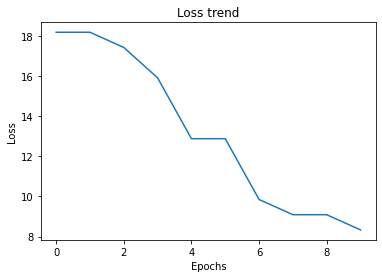

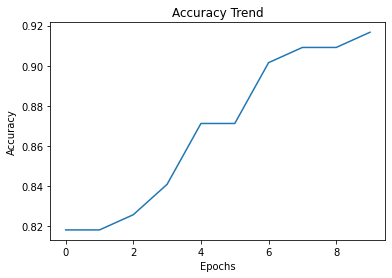

In [24]:
#training
losses = []
accuracies = []
for ep in range(EPOCHS):
    #training
    #print(f"Epoch {ep+1}\n-------------------------------")
    for i in range(len(X_train)):
        y_pred = bin_nn(X_train[i])
        loss = loss_fn(y_pred, y_train[i])
        current = i * BATCH_SIZE
        #if i % BATCH_SIZE == 0:
            #print(f"loss:  {loss.item():} [current: {current}/]")
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #testing
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i in range(len(X_test)):
            y_pred = torch.round(bin_nn(X_test[i]))
            test_loss += loss_fn(y_pred, y_test[i]).item()
            
            correct += (y_pred == y_test[i]).type(torch.float).sum().item()
            

    test_loss /= len(scaled_X_test)
    losses.append(test_loss)
    correct /= len(scaled_X_test)
    accuracies.append(correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
#printing loss   
plt.plot(losses)
plt.title('Loss trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#printing accuracy
plt.plot(accuracies)
plt.title('Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



Quanto descritto precedentemente trova conferma nell'output sopra il cui grafico, ottenuto attraverso una rappresentazione offerta dalla libreria python matplotlib, mostra una decrescita dell'errore di perdita della rete neurale e una proporzionale crescita dell'accuratezza della rete stessa. 

time required by cpu to train the model 12.509439189189191seconds
time required by cuda to train the model 5.427939189189189e-10seconds


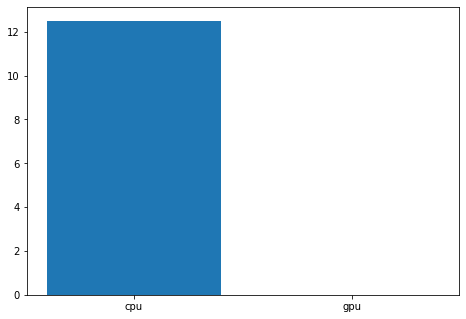

In [23]:
import warnings
warnings.filterwarnings('ignore')

#profiler
cpu_total = 0
cuda_total = 0
for i in range(len(X_train)):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, with_stack=True) as prof:
        with record_function("model_inference"):
            bin_nn(X_train[i]) 

    cpu_total += prof.key_averages().total_average().cpu_time_total
    cuda_total += prof.key_averages().total_average().cuda_time_total

avg_cpu = cpu_total / len(X_train)
avg_cuda = cuda_total / len(X_train)
    
cpu_sec = avg_cpu * 10 ** -3 
cuda_sec = avg_cuda * 10 ** -12

print(f'time required by cpu to train the model {cpu_sec}seconds')
print(f'time required by cuda to train the model {cuda_sec}seconds')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = [cpu_sec, cuda_sec]
axs = ['cpu','gpu']

ax.bar(axs, vals)
plt.show()

Come ultimo artefatto, viene riportato un breve benchmarking effettuato per dimostrare la differenza significativa rispetto all'esecuzione dell'algoritmo sulla CPU e quella svolta in parallelo grazie a CUDA sulla GPU. Per fare ciò è stato utilizzato il modulo Profiler messo a disposizione da pytorch attraverso il quale si possono ricavare le tempistiche delle operazioni di algebra lineare svolte dal modello rispettivamente per le due unità di processamento già citate. Una volta calcolato il tempo medio di esecuzione su CPU e GPU è facile notare dal grafico approssimativo e dai dati stampati a video quanto notevole sia la differenza di esecuzione in parallelo sulla GPU rispetto a quella 'canonica' sul processore.